Importing the libraries and dataset

In [2]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from datetime import datetime
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from datetime import datetime
plt.style.use('seaborn-v0_8-darkgrid')
import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb
from tensorflow import keras
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from math import sqrt
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from datetime import datetime
plt.style.use('seaborn-v0_8-darkgrid')
# Modelling and Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
#LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

%matplotlib inline
import warnings
warnings.filterwarnings('once')

In [3]:
dataset = pd.read_csv('C:/Users/diana/Desktop/proiect test/energy_client/client_1.csv')


# Load data from separate CSV files
#df_meter1 = pd.read_csv('meter1.csv')
#df_meter2 = pd.read_csv('meter2.csv')
#df_meter3 = pd.read_csv('meter3.csv')

# Add meter identifier column
#df_meter1['meter_id'] = 'Meter1'
#df_meter2['meter_id'] = 'Meter2'
#df_meter3['meter_id'] = 'Meter3'

# Concatenate DataFrames
#combined_data = pd.concat([df_meter1, df_meter2, df_meter3], ignore_index=True)

# Explore and preprocess the combined dataset as needed
# ...

# Further data processing and modeling can be performed on the combined_data DataFrame

Data exploration

In [4]:
dataset.head()

,Meter No.,Data Start Time,Data End Time,Active energy import A+(1.8.0)
0,21102097598,2023-05-21 23:45:00,2023-05-22 00:00:00,0.229
1,21102097598,2023-05-21 23:30:00,2023-05-21 23:45:00,0.234
2,21102097598,2023-05-21 23:15:00,2023-05-21 23:30:00,0.235
3,21102097598,2023-05-21 23:00:00,2023-05-21 23:15:00,0.231
4,21102097598,2023-05-21 22:45:00,2023-05-21 23:00:00,0.231


In [5]:
dataset.shape

(666, 4)

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666 entries, 0 to 665
Data columns (total 4 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Meter No.                       666 non-null    int64  
 1   Data Start Time                 666 non-null    object 
 2   Data End Time                   666 non-null    object 
 3   Active energy import A+(1.8.0)  666 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 20.9+ KB


In [7]:
dataset = dataset.drop(columns=['Data Start Time', 'Meter No.'])

In [8]:
dataset['Data End Time'] = pd.to_datetime(dataset['Data End Time'], format='%Y-%m-%d %H:%M:%S')
dataset = dataset.set_index('Data End Time')
dataset = dataset.sort_index()
dataset = dataset.asfreq('15min')
dataset = dataset.rename(columns={'Active energy import A+(1.8.0)': 'Demand'})
dataset.head()

,Demand
Data End Time,
2023-05-15 00:15:00,0.128
2023-05-15 00:30:00,0.128
2023-05-15 00:45:00,0.128
2023-05-15 01:00:00,0.112
2023-05-15 01:15:00,0.097


In [9]:
# check if there are any null values
dataset.isnull().values.any()

True

In [10]:
# check how many null values
dataset.isnull().values.sum()

6

In [11]:
dataset = dataset.interpolate()

Splitting the dataset into train set and test set

In [12]:
# Split data into train-val-test
# ==============================================================================
dataset = dataset.loc['2023-05-15 00:15:00': '2023-05-22 00:00:00'].copy()
end_train = '2023-05-20 14:00:00'
end_validation = '2023-05-21 7:00:00'
data_train = dataset.loc[: end_train, :].copy()
data_val   = dataset.loc[end_train:end_validation, :].copy()
data_test  = dataset.loc[end_validation:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2023-05-15 00:15:00 --- 2023-05-20 14:00:00  (n=536)
Validation dates : 2023-05-20 14:00:00 --- 2023-05-21 07:00:00  (n=69)
Test dates       : 2023-05-21 07:00:00 --- 2023-05-22 00:00:00  (n=69)


Graphic exploration

Full time series

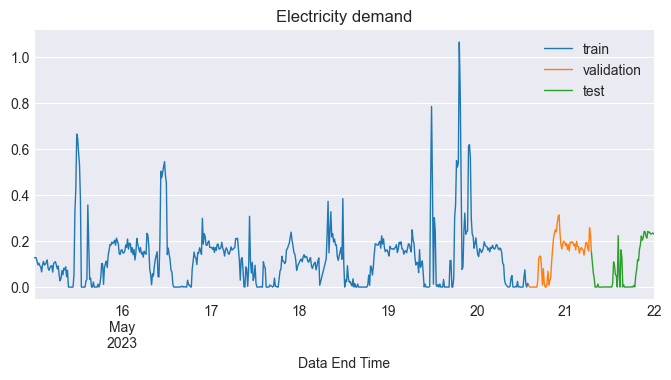

In [13]:
# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
data_train.Demand.plot(ax=ax, label='train', linewidth=1)
data_val.Demand.plot(ax=ax, label='validation', linewidth=1)
data_test.Demand.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Electricity demand')
ax.legend()

Text(0.5, 0.98, '')

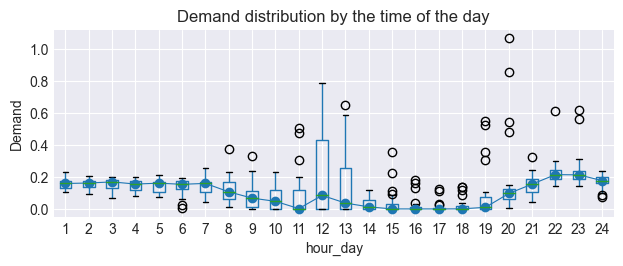

In [14]:
# Boxplot for daily seasonality
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
dataset['hour_day'] = dataset.index.hour + 1 # type: ignore
dataset.boxplot(column='Demand', by='hour_day', ax=ax)
dataset.groupby('hour_day')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Demand distribution by the time of the day')
fig.suptitle('')

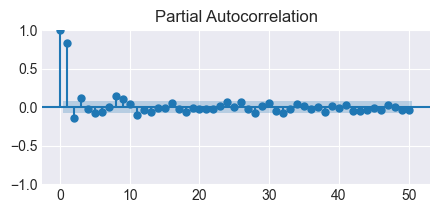

In [15]:
# Partial autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_pacf(dataset.Demand, ax=ax, lags=50)
plt.show()

Recursive multi-step forecasting

In [16]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 24,
                 transformer_y = StandardScaler()
             )

forecaster.fit(y=dataset.loc[:end_validation, 'Demand'])
forecaster

ForecasterAutoreg 
Regressor: Ridge(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2023-05-15 00:15:00'), Timestamp('2023-05-21 07:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: 15T 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-10-16 20:42:16 
Last fit date: 2023-10-16 20:42:16 
Skforecast version: 0.8.1 
Python version: 3.10.0 
Forecaster id: None 

In [17]:
dataset.index

DatetimeIndex(['2023-05-15 00:15:00', '2023-05-15 00:30:00',
               '2023-05-15 00:45:00', '2023-05-15 01:00:00',
               '2023-05-15 01:15:00', '2023-05-15 01:30:00',
               '2023-05-15 01:45:00', '2023-05-15 02:00:00',
               '2023-05-15 02:15:00', '2023-05-15 02:30:00',
               ...
               '2023-05-21 21:45:00', '2023-05-21 22:00:00',
               '2023-05-21 22:15:00', '2023-05-21 22:30:00',
               '2023-05-21 22:45:00', '2023-05-21 23:00:00',
               '2023-05-21 23:15:00', '2023-05-21 23:30:00',
               '2023-05-21 23:45:00', '2023-05-22 00:00:00'],
              dtype='datetime64[ns]', name='Data End Time', length=672, freq='15T')

In [18]:
# Backtest
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = dataset['Demand'],
                          steps              = 24,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(dataset.loc[:end_validation]),
                          refit              = False,
                          verbose            = True,
                          show_progress      = True
                    )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 604
Number of observations used for backtesting: 68
    Number of folds: 3
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 20 observations.

Fold: 0
    Training:   2023-05-15 00:15:00 -- 2023-05-21 07:00:00  (n=604)
    Validation: 2023-05-21 07:15:00 -- 2023-05-21 13:00:00  (n=24)
Fold: 1
    Training:   2023-05-15 00:15:00 -- 2023-05-21 07:00:00  (n=604)
    Validation: 2023-05-21 13:15:00 -- 2023-05-21 19:00:00  (n=24)
Fold: 2
    Training:   2023-05-15 00:15:00 -- 2023-05-21 07:00:00  (n=604)
    Validation: 2023-05-21 19:15:00 -- 2023-05-22 00:00:00  (n=20)



  0%|          | 0/3 [00:00<?, ?it/s]

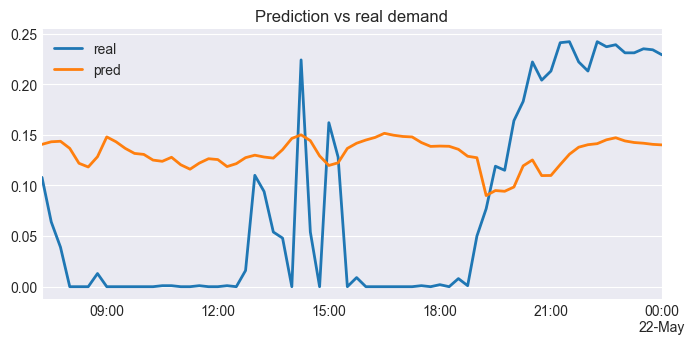

In [19]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
dataset.loc[predictions.index, 'Demand'].plot(ax=ax, linewidth=2, label='real')
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real demand')
ax.legend()

In [20]:
# Backtest error
# ==============================================================================
print(f'Backtest error: {metric}')

Backtest error: 0.10424078347793594


Hyperparameter tuning

In [21]:
# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 24, # This value will be replaced in the grid search
                 transformer_y = StandardScaler()
             )

# Lags used as predictors
lags_grid = [5, 24, [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Regressor's hyperparameters
param_grid = {'alpha': np.logspace(-3, 5, 10)}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = dataset.loc[:end_validation, 'Demand'],
                   steps              = 24,
                   metric             = 'mean_absolute_error',
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   initial_train_size = len(dataset[:end_train]),
                   refit              = False,
                   return_best        = True,
                   verbose            = False
               )

Number of models compared: 30.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47 48 49] 
  Parameters: {'alpha': 0.001}
  Backtesting metric: 0.06591040477215758



In [22]:
forecaster

ForecasterAutoreg 
Regressor: Ridge(alpha=0.001, random_state=123) 
Lags: [ 1  2  3 23 24 25 47 48 49] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 49 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2023-05-15 00:15:00'), Timestamp('2023-05-21 07:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: 15T 
Regressor parameters: {'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-10-16 20:42:17 
Last fit date: 2023-10-16 20:42:18 
Skforecast version: 0.8.1 
Python version: 3.10.0 
Forecaster id: None 

Backtest with test data

  0%|          | 0/3 [00:00<?, ?it/s]

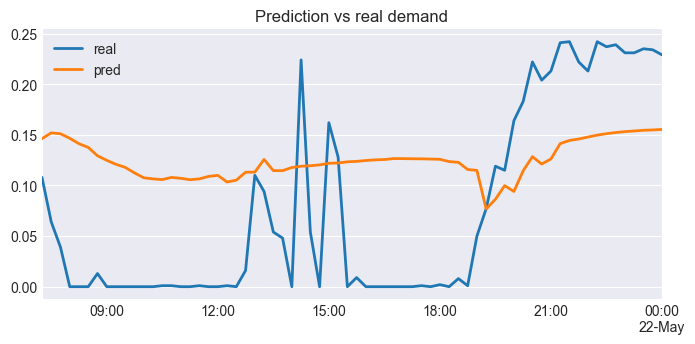

In [23]:
# Backtest final model
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = dataset['Demand'],
                          steps              = 24,
                          metric             = mean_absolute_error,
                          initial_train_size = len(dataset[:end_validation]),
                          refit              = False,
                          verbose            = False,
                          show_progress      = True
                      )

fig, ax = plt.subplots(figsize=(8, 3.5))
dataset.loc[predictions.index, 'Demand'].plot(linewidth=2, label='real', ax=ax)
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real demand')
ax.legend()

In [24]:
# Backtest error
# ==============================================================================
print(f'Backtest error: {metric}')

Backtest error: 0.09364288646306027


In [25]:
# Backtest error
# ==============================================================================
error = mean_absolute_error(
            y_true = dataset.loc[predictions.index, 'Demand'],
            y_pred = predictions
        )

print(f"Backtest error: {error}")

Backtest error: 0.09364288646306027
